### Lab Assignment Two: Exploring Image Data

You are to perform preprocessing and exploratory analysis of a data set: exploring the statistical summaries of the features, visualizing the attributes, and addressing data quality. This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output.

**Dataset requirements**: Choose a dataset that is comprised of image data. The data should be directories of images. That is, the dataset should not yet be pre-processed. The following are required for the dataset:

- **Stanford Dogs Dataset**
- URL: http://vision.stanford.edu/aditya86/ImageNetDogs/

**Dataset Reference**

**Primary:**
Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. **Novel dataset for Fine-Grained Image Categorization.** *First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*, 2011.  [[pdf]](http://people.csail.mit.edu/khosla/papers/fgvc2011.pdf)  [[poster]](http://vision.stanford.edu/documents/KhoslaJayadevaprakashYaoFeiFei_FGVC2011.pdf)  [[BibTex]](http://vision.stanford.edu/bibTex/KhoslaJayadevaprakashYaoFeiFei_FGVC2011.bib)

**Secondary:**
J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li and L. Fei-Fei, **ImageNet: A Large-Scale Hierarchical Image Database.** *IEEE Computer Vision and Pattern Recognition (CVPR)*, 2009.  [[pdf]](http://www.image-net.org/papers/imagenet_cvpr09.pdf)  [[BibTex]](http://www.image-net.org/papers/imagenet_cvpr09.bib)

1. The data includes at least 1000 images
    1. Number of images: 20,580
    2. There are 20,580 images, out of which 12,000 are used for training and 8580 for testing. Class labels and bounding box annotations are provided for all the 12,000 images.
2. The size of the images should be larger than 20x20 pixels
    1. `Smallest image size: 97x100 pixels`
3. The dataset should have a well defined prediction task (i.e., a label for each image)
    1. The well-defined prediction task for the **Stanford Dogs Dataset** dataset involves classifying the breed of a dog from its image.
4. The dataset cannot be MNIST or Fashion MNIST
    1. Correct, the Stanford Dogs Dataset is not MNIST or Fashion MNIST.

A note on grading: This lab is mostly about visualizing and understanding your dataset. The largest share of the points is from how you interpret the visuals that you make. Making the visuals is not enough to satisfy each of the rubrics below—you should appropriately explain what the implications of the visualizations are. In other words, expect about 20% of the available points for visuals that have no substantive discussion.

**Grading Rubric**

- Business Understanding (**2 points total**).
    - [**2 points**] Give an overview of the dataset.
        - The Stanford Dogs Dataset is a collection of images featuring 120 breeds of dogs from around the world. This dataset has been built using images and annotations from ImageNet for the task of classification. It contains over 20,000 images, each labeled with the breed of the dog present in the image.
    - Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?).
        - The dataset was collected in the first place to test machine learning and computer vision algorithms to recognize and predict the breed of a dog from its image.
    - What is the prediction task for your dataset and which third parties would be interested in the results?
        - The well-defined prediction task for the Stanford Dogs Dataset is the classification of dog breeds. The third parties that would be interested are Academic Researchers, Tech Companies and of course, Veterinarians.
    - Why is this data important?
        - For Researchers, the results can advance research in depth perception and structured prediction in machine learning and computer vision. Since dog breeds are so similar, identifying them requires a model to learn nuanced features, which can significantly contribute to advancements in the field.
    - Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties?
        - The model should have a high accuracy rate in correctly identifying dog breeds. In practice, an accuracy rate of over 80% might be expected for professional applications. For user experience, the model should be efficient in terms of computation time and resource usage. And of course, the model must maintain high performance on images that were not part of the training dataset.
    - Be specific and use your own words to describe the aspects of the data.

Exceptional Work (1 points total)

In [1]:
import cv2
import os
import tarfile
import io
from PIL import Image
import pandas as pd
import numpy as np
from numpy import dot as mmult
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import sklearn
from skimage.feature import daisy

# Print versions
print("cv2 version:", cv2.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("missingno version:", msno.__version__)
print("sklearn version:", sklearn.__version__)

cv2 version: 4.6.0
pandas version: 2.1.4
numpy version: 1.26.3
matplotlib version: 3.8.0
seaborn version: 0.12.2
missingno version: 0.4.2
sklearn version: 1.2.2


In [2]:
label_tar_path = 'stanford_dogs/annotation.tar'

file_labels = {}

with tarfile.open(label_tar_path) as tar:
    for member in tar.getmembers():
        path_parts = member.name.split('/')
        if len(path_parts) >= 2:
            label = path_parts[1].split('-')[1]
            file_key = os.path.splitext(path_parts[-1])[0]
            file_labels[file_key] = label

To generate processed_images while integrating labels from annotation.tar, I need to adapt my code to include each image's label using the file_labels dictionary. I'll extract filenames from images.tar, match them with labels, and store them as tuples in processed_images. This tuple structure will pair each image array with its corresponding label for easy tracking. I'll then utilize this combined data for subsequent tasks like flattening images and adding labels to a NumPy array before PCA.

In [3]:
tar_path = 'stanford_dogs/images.tar'
smallest_width, smallest_height = float('inf'), float('inf')

with tarfile.open(tar_path) as tar:
    for member in tar.getmembers():
        if member.name.lower().endswith(('.jpg', '.jpeg', '.png')):
            file = tar.extractfile(member)
            if file:
                img = Image.open(io.BytesIO(file.read()))

                width, height = img.size
                smallest_width = min(smallest_width, width)
                smallest_height = min(smallest_height, height)

                img.close()

print(f'Smallest image size: {smallest_width}x{smallest_height} pixels')

Smallest image size: 97x100 pixels


Iterate through each image file within the specified tar archive. For each image, it reads its content, determines its width and height, and updates the smallest width and height encountered so far. After processing all images, it prints out the smallest image size found.

[.5 points] Resize and recolor images as necessary. 

In [4]:
processed_images = []

with tarfile.open(tar_path) as tar:
    for member in tar.getmembers():
        if member.name.lower().endswith(('.jpg', '.jpeg', '.png')):
            file = tar.extractfile(member)
            if file:
                img = Image.open(io.BytesIO(file.read()))
                
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                img = img.resize((smallest_width, smallest_height))
                
                img_array = np.array(img)
                
                filename_key = os.path.splitext(os.path.basename(member.name))[0]

                label = file_labels.get(filename_key, "Unknown")

                processed_images.append((img_array, label))
                
                img.close()

This code processes images stored within a tar archive. It iterates through each member of the archive, checks if it's an image file (ending with '.jpg', '.jpeg', or '.png'), extracts it, converts it to RGB mode if necessary, resizes it to a predefined width and height, converts it into a NumPy array, associates it with a label based on its filename, and finally stores the image array-label pair in a list for further use.

Data Preparation (1 points total)
[.1 points] Visualize several images.

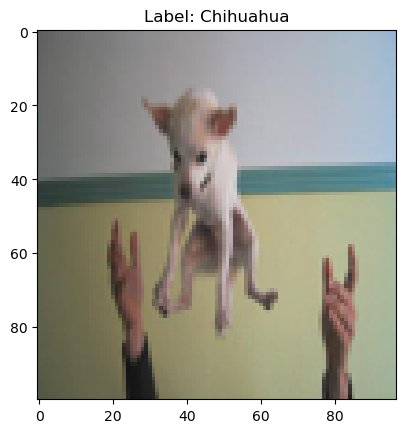

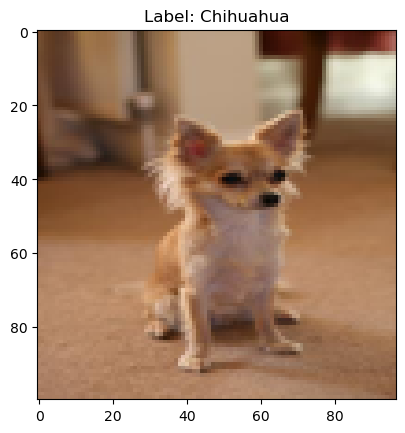

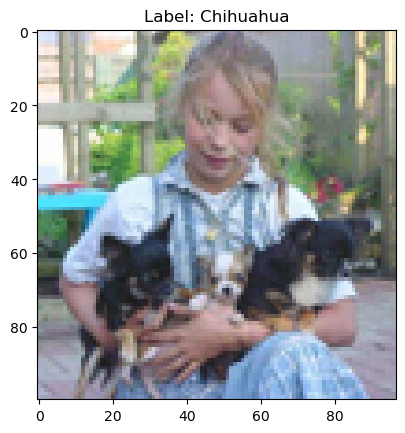

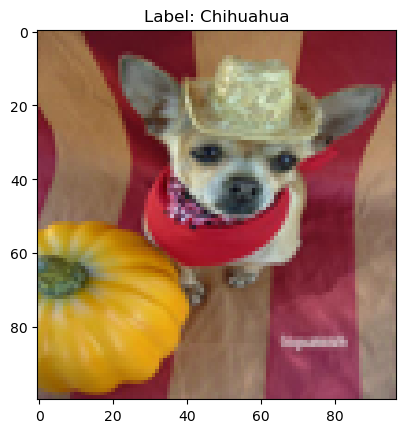

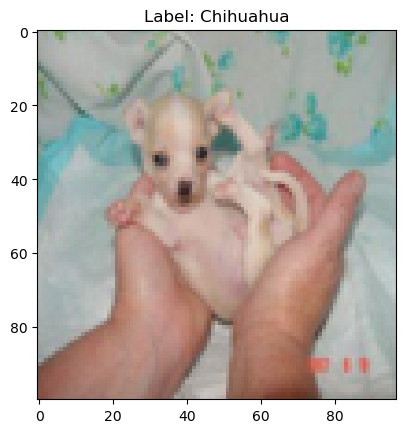

In [5]:
# Visualize first few images along with their labels
for img, label in processed_images[:5]:
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.show()

Data Preparation (1 points total)

[.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary. 

[.4 points] Linearize the images to create a table of 1-D image features (each row should be one image).   


Given that each element in processed_images is a tuple containing both the image array and its corresponding label, we just need to flatten only the image portion of each tuple.

In [6]:
linearized_images_with_labels = []
flattened_images = []
labels = []
for img, label in processed_images:
    flattened_img = np.array(img).flatten()
    linearized_images_with_labels.append((flattened_img, label))
    flattened_images.append(flattened_img)
    labels.append(label)

In [7]:
X_pca = np.array(flattened_images)
Y_pca = np.array(labels)
X_randomized_pca = np.array(flattened_images)
Y_randomized_pca = np.array(labels)

When dealing with a particularly large dataset and facing memory limitations on my machine, I encountered issues trying to fit a PCA (Principal Component Analysis) model directly on the entire dataset. 
To address this challenge, I wanted to use IncrementalPCA, a model designed specifically for working with large datasets in a memory-efficient manner.

In [8]:
n_components = 200 
batch_size = 1000

ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

def generate_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

# Iterate over batches and fit IncrementalPCA
for X_batch in generate_batches(X_pca, batch_size):
    ipca.partial_fit(X_batch)

In [9]:
# Transform the entire dataset using the fitted IncrementalPCA
X_pca_transformed = ipca.transform(X_pca)

In [10]:
cumulative_variance = np.cumsum(ipca.explained_variance_ratio_)

Visualize Explained Variance:
Plot the cumulative explained variance against the number of components. This visualization helps determine how many components are needed to represent the data adequately.

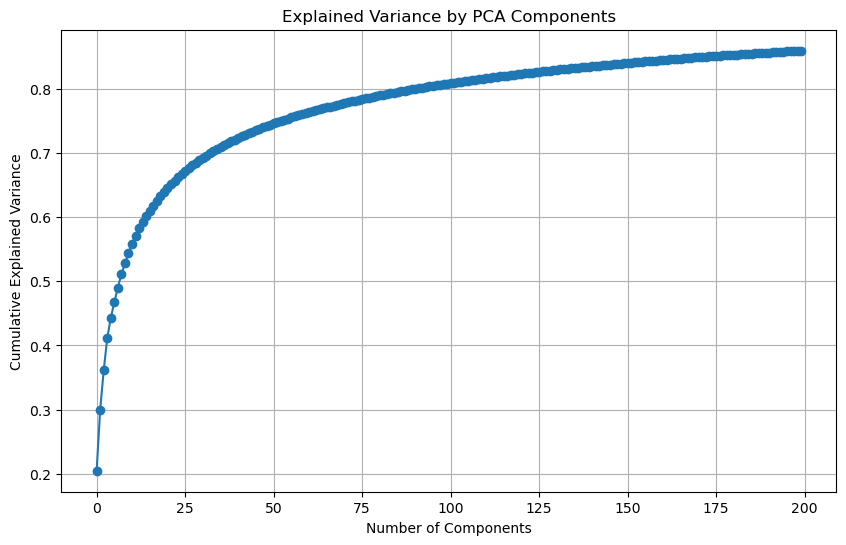

In [11]:
# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

When Determining the number of PCAs, it is a good rule of thumb to look for the 'elbow' in the Number of Components vs Cumulative Explained Variance plot. After the 'elbow', the cumulative variance starts to have diminishing returns. This point is typically considered an adequate balance between information retention and dimensionality reduction.

The provided graph displays the cumulative explained variance by the number of principal components from a PCA analysis. From this graph, up to the 75th component, there is a rapid increase in explained variance, indicating that these components capture most of the significant information from the dataset.
After approximately 75 components, the curve's slope decreases, suggesting that each additional component contributes less to the model's explanatory power.

75 number of components balances capturing the variance (information) but also reduces the dimensions effectively.

[.**5 points**] Perform linear dimensionality reduction of your image data using **randomized principle components analysis**.
- Visualize the explained variance of each component.
- Analyze how many dimensions are required to adequately represent your image data.
- Explain your analysis and conclusion.

In [12]:
n_components = 75 # from standard PCA
randomized_pca = PCA(n_components=n_components, svd_solver='randomized', random_state=33)

In [13]:
# Fit the PCA model to the image data
randomized_pca.fit(X_randomized_pca)

PCA(n_components=75, random_state=33, svd_solver='randomized')

In [14]:
# Transform the entire dataset using the fitted PCA
X_randomized_pca_transformed = randomized_pca.transform(X_randomized_pca)

In [15]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(randomized_pca.explained_variance_ratio_)

- Visualize the explained variance of each component.

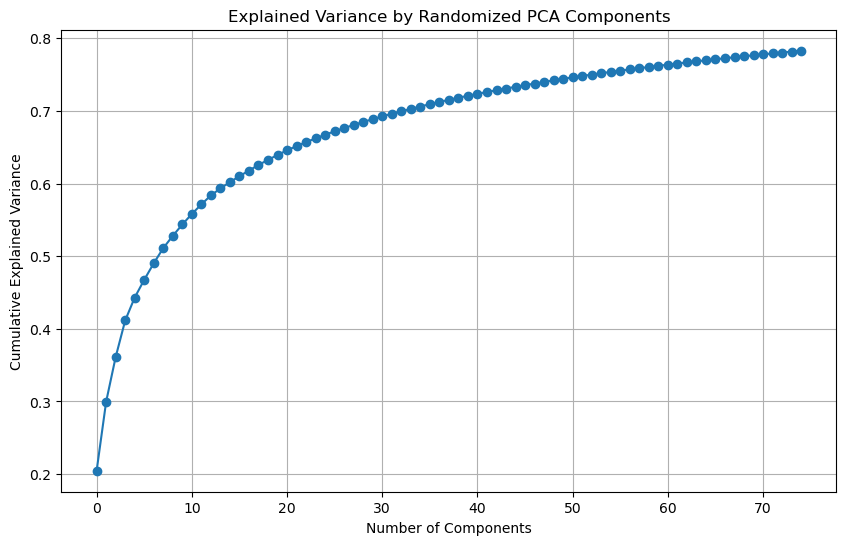

In [16]:
# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Randomized PCA Components')
plt.grid(True)
plt.show()

- Analyze how many dimensions are required to adequately represent your image data.
- Explain your analysis and conclusion.

This graph illustrates the cumulative explained variance based on the number of principal components derived from a PCA analysis. It demonstrates a steep rise in explained variance up to the 30th component, suggesting that these components effectively capture the majority of significant information from the dataset. Beyond approximately 30 components, the curve's incline becomes less pronounced, indicating diminishing returns in terms of each additional component's contribution to the model's explanatory power.

Having 30 components strikes a balance between capturing variance (information) and effectively reducing dimensions.

[**2 points**] Compare the representation using PCA and Randomized PCA.
- The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.

To compare the representation using PCA and Randomized PCA, we can analyze their cumulative explained variance curves and assess their performance in representing images with fewer components quantitatively.

- For PCA: Up to the 75th component, there is a rapid increase in explained variance, indicating effective capture of significant information. Beyond 75 components, the rate of increase slows down, suggesting diminishing returns in explanatory power.
- For Randomized PCA: Up to the 30th component, there is a rapid increase in explained variance, indicating effective capture of significant information. Beyond 30 components, the rate of increase slows down, suggesting diminishing returns in explanatory power.

Quantitatively, PCA captures more variance with 75 components compared to Randomized PCA's 30 components, suggesting a more comprehensive representation. However, Randomized PCA may offer faster computation, making it preferable for large datasets with limited computational resources.

- Do you prefer one method over another? Why?

The decision to use Randomized PCA was driven by limitations in memory and computational resources. This variant of Principal Component Analysis offers faster computation, making it suitable for large datasets where traditional PCA might be impractical. Although Randomized PCA sacrifices some variance capture compared to standard PCA, this trade-off is acceptable given the priority of conserving computational resources. Thus, Randomized PCA was chosen to strike a balance between computational efficiency and accuracy in dimensionality reduction.

[1 points] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, DAISY, etc.).

In [17]:
expected_num_images, expected_num_features = X_pca.shape

print("Expected number of images:", expected_num_images)
print("Expected number of features per image:", expected_num_features)

Expected number of images: 20580
Expected number of features per image: 29100


The daisy function from the scikit-image library expects a 2-dimensional array as input because it operates on grayscale images. It computes DAISY descriptors, which are local image descriptors designed for grayscale images. These descriptors capture local spatial structures in the image, which are typically encoded in intensity variations.

While it's possible to apply DAISY feature extraction to color images, it requires additional preprocessing steps. One common approach is to convert the color image to a grayscale image and then compute DAISY descriptors on the grayscale version. However, this approach discards color information, which might be important for certain tasks.

If you want to keep color information while using DAISY features, you can extract separate DAISY descriptors for each color channel (e.g., red, green, and blue) and concatenate them together. This way, you can preserve color information while still leveraging DAISY descriptors for feature extraction.

In [18]:
subset_size = 20000 

# DAISY parameters
radius = 15
num_rings = 3
num_hist_bins = 8
num_orientations = 8

subset_features = []
y_subset = []

for img, label in processed_images[:subset_size]:
    # Compute DAISY features for each color channel
    channel_features = []
    for channel in range(img.shape[2]):
        daisy_features = daisy(img[:, :, channel], step=8, radius=radius, rings=num_rings, histograms=num_hist_bins, orientations=num_orientations)
        flattened_features = daisy_features.reshape(-1)
        channel_features.append(flattened_features)
    
    concatenated_features = np.concatenate(channel_features)
    
    subset_features.append(concatenated_features)
    
    y_subset.append(label)

# Convert the feature list and label list to numpy arrays
X_subset = np.array(subset_features)
y_subset = np.array(y_subset)

In [ ]:
# Check the mean and standard deviation of each feature
feature_means = np.mean(X_subset, axis=0)
feature_stds = np.std(X_subset, axis=0)

print("Feature means:", feature_means)
print("Feature standard deviations:", feature_stds)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled, y_train)

y_pred = knn_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of KNN Classifier with standardized features: {accuracy}")

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

[**2 points**] Does this feature extraction method show promise for your prediction task?
- Why? Use visualizations to analyze this questions.
- For example, visualize the differences **between statistics of extracted features** in each target class.
- Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features.
- Another option, build a nearest neighbor classifier to see actual classification performance.

Based on the provided confusion matrix and the reported accuracy of our KNN classifier (0.0635), it's clear that our feature extraction method isn't performing well for the prediction task. The accuracy is very low, indicating that our classifier is only slightly better than random guessing, assuming a large number of classes.

The confusion matrix indicates significant misclassification, with non-zero values spread far from the diagonal. This suggests inadequate separation of classes by the extracted features, potentially due to imbalanced data or inadequate feature representation.

Exceptional Work (**1 points total**)
- You have free reign to provide any additional analyses.
- One idea (**required for 7000 level students**): Perform feature extraction upon the images using DAISY. Rather than using matching on the images with the total DAISY vector, you will **instead use key point matching**. You will need to investigate appropriate methods for key point matching using DAISY. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive. Does it perform better than not using key point matching?

In [ ]:
# helped by ChatGPT to write the extract_daisy_keypoints function
def extract_daisy_keypoints(image):
    keypoints = cv2.goodFeaturesToTrack(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), maxCorners=1000, qualityLevel=0.01, minDistance=10)
    keypoints = [cv2.KeyPoint(x=kp[0][0], y=kp[0][1], _size=10) for kp in keypoints]
    keypoints, descriptors = cv2.readMoreFromImage(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), keypoints)
    return keypoints, descriptors

# Extract DAISY keypoints and descriptors for each image
subset_keypoints = []
subset_descriptors = []
for img, label in processed_images[:subset_size]:
    keypoints, descriptors = extract_daisy_keypoints(img)
    subset_keypoints.append(keypoints)
    subset_descriptors.append(descriptors)

# Perform keypoint matching
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = []
for i in range(len(subset_descriptors) - 1):
    matches.append(matcher.match(subset_descriptors[i], subset_descriptors[i+1]))

num_matches = [len(match) for match in matches]
for i, num_match in enumerate(num_matches):
    print(f"Number of matches for image pair {i}: {num_match}")

Keypoint matching is essential in various computer vision tasks such as object recognition, image registration, and structure from motion.
DAISY features offer robustness to changes in viewpoint and illumination, making them suitable for tasks where traditional methods like SIFT or SURF may not perform well.

Performs keypoint matching between a set of images using DAISY features.
It involves extracting DAISY keypoints and descriptors from a subset of processed images, and then matching these keypoints between consecutive images to find correspondences.